In [ ]:
from collections import deque
import heapq as hq
import numpy as np

rng = np.random.default_rng(seed=42)

class Trade: 
    def __init__(self, bid_id, ask_id, price, volume):
        self.bid_id = bid_id
        self.ask_id = ask_id
        self.price = price
        self.volume = volume
    
class Order: 
    _id_counter = 0 

    def __init__(self, price=None, volume=100, is_bid=True, is_market=False):
        self.price = price 
        self.volume = volume 
        self.is_bid = is_bid
        self.id = Order._id_counter
        Order._id_counter += 1

        #is_market flag for a market order
        self.is_market = is_market

class PriceLevel:
    def __init__(self, price):
        self.price = price 
        self.orders = deque()
    
    def add(self, order):
        self.orders.append(order)

    def top(self):
        if not self.orders:
            return None
        return self.orders[0] # O(1)

    def pop(self):
        if not self.orders:
            raise IndexError("Price level is empty.")
        return self.orders.popleft() # O(1)
    
    def fill(self, volume):
        to_fill = volume
        filled = 0

        while not self.is_empty(): 
            top_order = self.top()

            if top_order.volume > to_fill: 
                filled += to_fill
                top_order.volume -= to_fill
                to_fill = 0 
                break

            elif top_order.volume == to_fill: 
                filled += to_fill 
                self.pop()
                to_fill = 0 
                break

            else: 
                filled += top_order.volume
                to_fill -= top_order.volume
                self.pop()

        return filled
        

    def cancel(self, order):
        try:
            self.orders.remove(order) # O(n)
        except ValueError:
            raise ValueError("Order not found at this price level.")
        
    def is_empty(self):
        return True if len(self.orders) == 0 else False

class PriceBook:
    def __init__(self, is_bid_side):
        self._price_levels = {}
        self._heap = []
        self.is_bid_side = is_bid_side

    def add(self, order): 
        price = order.price

        if price not in self._price_levels:
            self._price_levels[price] = PriceLevel(price)
            # Use negative price for max-heap behavior on bid side.
            heap_price = -price if self.is_bid_side else price
            hq.heappush(self._heap, heap_price)

        self._price_levels[price].add(order)
    
    def cancel(self, order):
        price = order.price
        if price not in self._price_levels:
            raise ValueError(f"Price {price} not found in PriceBook.")

        try:
            self._price_levels[price].cancel(order)
            # Trying to remove the price level from the heap here would be O(N)
        except ValueError as e:
            # Propagate the original error — don't swallow it
            raise ValueError(f"Failed to cancel order {order.id}: {e}") from e

    def best_price(self):
        if not self._price_levels: 
            return None
        else:
            # Since I didn't remove empty price levels upon order cancellation I have to handle it here
            while self._heap:
                best_price = - self._heap[0] if self.is_bid_side else self._heap[0]
                # Remove empty price levels
                if self._price_levels[best_price].is_empty():
                    hq.heappop(self._heap)
                    del self._price_levels[best_price]
                else: 
                    break

            if self._heap:
                return best_price
            else:
                return None
            
    def peek_best_order(self):
        best_price = self.best_price()
        if best_price:
            return self._price_levels[best_price].top()
        else:
            return None
        
    def fill_volume(self, volume, price): 
        to_fill = volume
        filled = {}
        best_price = self.best_price()

        while best_price and to_fill > 0:
            
            # Check whether prices are compatible
            can_fill = (best_price >= price) if self.is_bid_side else (best_price <= price)

            if can_fill:
                filled_at_price = self._price_levels[best_price].fill(to_fill)
                to_fill -= filled_at_price
                filled[best_price] = filled_at_price
            else:
                break
            
            # This simultaneously removes empty price levels and establishes next best_price
            best_price = self.best_price()

        # Return a dictionary price -> volume filled at price
        return filled
        
class OrderBook:

    def __init__(self, start_value=100):
        self.bids = PriceBook(is_bid_side=True)
        self.asks = PriceBook(is_bid_side=False)
        self.order_map = dict()
        self.start_value = start_value
        self.fundamental_value = start_value
        self.volatility = 0.5

        # Volume traded in a timestep 
        self.buy_volume = 0
        self.sell_volume = 0
    
    @property
    def best_bid(self):
        return self.bids.best_price()
    
    @property
    def best_ask(self):
        return self.asks.best_price()
    
    @property 
    def spread(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round(self.best_ask-self.best_bid, 2)
    
    @property 
    def mid_price(self):
        if self.best_bid == None or self.best_ask == None:
            return None
        else: 
            return round((self.best_ask + self.best_bid) / 2, 2)
    
    def process_order(self, order):

        if order.is_bid: 
            filled = self.asks.fill_volume(order.volume, order.price)
        else:
            filled = self.bids.fill_volume(order.volume, order.price)
        
        filled_volume = sum(filled.values())

        # Only add remaining volume to book if it is a limit order
        if filled_volume < order.volume and not order.is_market:
            order.volume -= filled_volume
            self.order_map[order.id] = order

            if order.is_bid:
                self.bids.add(order)
            else:
                self.asks.add(order)
        
        # Update volumes traded this timestep 
        if order.is_bid:
            self.buy_volume += filled_volume
        else:
            self.sell_volume += filled_volume 
        
        return filled
    
    # A helper function to reset the trading volumes at each timestep
    def reset_volumes(self):
        self.buy_volume = 0 
        self.sell_volume = 0

    def update_fundamental_value(self):
        # Simple random walk for fundamental value
        self.fundamental_value += rng.normal(-0.2, self.volatility)

    def cancel(self, order_id):
        try: 
            order = self.order_map[order_id]
        except KeyError as e: 
            raise KeyError(f"Order with id {order_id} could not be found: {e}")

        if order.is_bid:
            self.bids.cancel(order)
        else:
            self.asks.cancel(order)

        del self.order_map[order_id]

In [352]:
class OrderFlow: 

    def __init__(self, arrival_rate=100, max_offset=0.01, min_volume=10, max_volume=100, info=0.2, noise=0.3):
        self.arrival_rate = arrival_rate
        self.max_offset = max_offset
        self.min_volume = min_volume
        self.max_volume = max_volume

        # Liquidity takers fraction
        self.info = info
        self.noise = noise

        # Track volume for analysis
        self.info_volume = 0
        self.noise_volume = 0
        self.mm_volume = 0
        
    def generate_orders(self, order_book):
        self.info_volume = 0
        self.noise_volume = 0 
        self.mm_volume = 0
        n_orders = rng.poisson(self.arrival_rate)
        orders = []

        if order_book.best_bid is None:
            best_bid = order_book.fundamental_value - 1
        else:
            best_bid = order_book.best_bid
        
        if order_book.best_ask is None:
            best_ask = order_book.fundamental_value + 1
        else:
            best_ask = order_book.best_ask

        if order_book.spread is None:
            max_offset = self.max_offset
        else:
            max_offset = min(self.max_offset, order_book.spread / 2)
        
        # To protect against very tight spreads
        min_offset = min(0.01, max_offset)

        # We model three types of traders: 
        # - aggressive informed traders (take liquidity in direction of fundamental value)
        # - aggressive noise traders (take liquidity randomly - exogenous reasons)
        # - market makers (providing liquidity with probability of queue jumping proportional to spread)
        
        for _ in range(n_orders):
            
            volume = rng.integers(self.min_volume, self.max_volume + 1)
            trader = rng.choice(['info', 'noise', 'mm'], p=[self.info, self.noise, 1 - self.info - self.noise])

            if trader == 'info':
                # Informed trader
                is_market = True
                if order_book.fundamental_value >= best_bid + best_ask / 2:
                    is_bid = True
                else:
                    is_bid = False
                price = float('inf') if is_bid else float('-inf')

                # Track volume
                self.info_volume += volume
            
            elif trader == 'noise':
                # Noise trader
                is_market = True
                is_bid = rng.random() < 0.5
                self.noise_volume += volume
                price = float('inf') if is_bid else float('-inf')

                # Track volume
                self.noise_volume += volume
            
            else:
                # Market makers
                is_market = False
                is_bid = rng.random() < 0.5
                target_spread_bps = order_book.volatility / 100
                target_spread = order_book.fundamental_value * target_spread_bps

                # if spread exists then there is a min bid, min ask and midpoint
                if order_book.spread is not None:
                    
                    # Market makers don't know fundamental value perfectly. 
                    target_spread = order_book.mid_price * target_spread_bps

                    # Depending on how far spread is from target, increase chance of queue jumping
                    if order_book.spread > 1.5 * target_spread:
                        p_q_jump = 0.2
                    elif target_spread > order_book.spread:
                        p_q_jump = 0.05
                    else:
                        p_q_jump = 0
                    
                    did_jump = rng.random() < p_q_jump

                    if did_jump:
                        if is_bid:
                            price = best_bid + 0.01
                        else:
                            price = best_ask - 0.01
                    else:
                        price = best_bid if is_bid else best_ask
                
                else:
                    
                    # Order book is thin - don't compete for spread
                    if is_bid:
                        if order_book.best_bid is None:
                            price = order_book.fundamental_value - target_spread / 2
                        else:
                            price = order_book.best_bid
                    else:
                        if order_book.best_ask is None:
                            price = order_book.fundamental_value + target_spread / 2
                        else:
                            price = order_book.best_ask

                price = round(price, 2)

                # Track market maker volume
                self.mm_volume += volume

            orders.append(Order(price, volume, is_bid, is_market))
        
        return orders

In [ ]:
class SimpleMarketMaker():
    def __init__(self, inventory_limit=float('inf'), quote_size=10000):
        self.inventory = 0
        self.cash = 0
        self.active_orders = {}

        self.inventory_limit = inventory_limit
        self.quote_size = quote_size

        self.num_bids = 0
        self.num_asks = 0
    
    def update(self, order_book):
        # First we check whether orders on the previous times tep were filled 
        for order_id, (price, volume, is_bid) in list(self.active_orders.items()):
            
            # Check for full fills 
            if order_id not in order_book.order_map:
                self._record_fill(price, volume, is_bid)
                del self.active_orders[order_id]

            # Check for partial fills  
            else: 
                remaining_volume = order_book.order_map[order_id].volume

                if remaining_volume == 0:
                    raise ValueError("A filled order remained on the books.")
                
                elif remaining_volume > volume:
                    raise ValueError("Order book's volume exceeds our count.")
                
                else: 
                    filled_volume = volume - remaining_volume 
                    self._record_fill(price, filled_volume, is_bid)
                    self.active_orders[order_id] = (price, remaining_volume, is_bid)
                
        # Generate an order via a strategy 
        orders = self.strategy(order_book)

        # Post Quote
        for order in orders:
            self.active_orders[order.id] = (order.price, order.volume, order.is_bid)
            order_book.process_order(order)
            print(f"{'bid' if order.is_bid else 'ask'}, volume {order.volume}")
            
    
    def _record_fill(self, price, volume, is_bid):
        print(f"Recording fill: price={price}, volume={volume}, is_bid={is_bid}")
        print(f"Before: inventory={self.inventory}")
        if is_bid: 
            # if volume > 0:
            #     self.num_bids += volume
            #     print("total num bids:", self.num_bids)
            self.cash -= price * volume 
            self.inventory += volume
            print(f"This was a BID fill (MM bought) - inventory INCREASED by {volume}")
        else:
            # if volume > 0:
            #     self.num_asks += volume
            #     print("total num asks:", self.num_asks)
            self.cash += price * volume 
            self.inventory -= volume 
            print(f"This was an ASK fill (MM sold) - inventory DECREASED by {volume}")
    
    def strategy(self, order_book):
        orders = []
        tick = 0.01
        if order_book.best_ask is None:
            ask = order_book.start_value + tick
        else:
            ask = round(order_book.best_ask - tick, 2)
        if order_book.best_bid is None:
            bid = order_book.start_value - tick
        else:
            bid = round(order_book.best_bid + tick, 2)

        # Basic Strategy: if too long we stop quoting bids, if too short we stop quoting asks.
        # If we have unfilled orders on the book replace them with new quotes
        for order_id in list(self.active_orders.keys()):
            try:
                order_book.cancel(order_id)
                del self.active_orders[order_id]
            except:
                # Order may already be filled (this exception shouldn't ever trigger.)
                pass

        if self.inventory < self.inventory_limit:
            orders.append(Order(bid, self.quote_size, True, False))

        if self.inventory > -self.inventory_limit:
            orders.append(Order(ask, self.quote_size, False, False))

        return orders
    
    def pnl(self, order_book):
        if order_book.mid_price: 
            unrealised_pnl = self.inventory * order_book.mid_price
        else:
            unrealised_pnl = order_book.fundamental_value * self.inventory
        total_pnl = self.cash + unrealised_pnl
        return total_pnl
    
    def get_stats(self):
        return {
            "Inventory" : self.inventory,
            "Cash" : self.cash
        }

In [376]:
import matplotlib.pyplot as plt
mm = SimpleMarketMaker()
of = OrderFlow()
ob = OrderBook()
rng = np.random.default_rng(seed=42)

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

def simulate(order_book, order_flow, market_maker, timesteps):
    # Market Maker Trackers 
    pnl = np.zeros(timesteps)
    mp = np.zeros_like(pnl)
    fund_value = np.zeros_like(pnl)
    cash = np.zeros_like(pnl)
    inventory = np.zeros_like(pnl)
    volume_traded = np.zeros_like(pnl)

    # Order Flow Trackers
    info_volume = np.zeros_like(pnl)
    noise_volume = np.zeros_like(pnl)
    mm_volume = np.zeros_like(pnl)

    # Order Book Trackers
    buy_volume = np.zeros_like(pnl)
    sell_volume = np.zeros_like(pnl)

    for t in range(timesteps):
        # Simulate order flow 
        orders = order_flow.generate_orders(order_book)
        for order in orders:
            order_book.process_order(order)
        
        # Market Maker updates quotes
        market_maker.update(order_book)
        order_book.update_fundamental_value()

        # trackers
        market_maker_stats = market_maker.get_stats()
        cash[t] = market_maker_stats["Cash"]
        inventory[t] = market_maker_stats["Inventory"]
        volume_traded[t] = order_book.buy_volume + order_book.sell_volume
        fund_value[t] = order_book.fundamental_value
        
        info_volume[t] = order_flow.info_volume
        noise_volume[t] = order_flow.noise_volume
        mm_volume[t] = order_flow.mm_volume

        buy_volume[t] = order_book.buy_volume
        sell_volume[t] = order_book.sell_volume

        # Reset order book volumes for next timestep
        order_book.reset_volumes()

        # Market Maker updates pnl
        pnl[t] = market_maker.pnl(order_book)
        print(order_book.best_bid)
        mp[t] = order_book.fundamental_value if order_book.mid_price is None else order_book.mid_price
    
    return [pnl, mp, fund_value, cash, inventory, volume_traded, info_volume, noise_volume, mm_volume, buy_volume, sell_volume]

tracker_names = [
    "PnL",
    "Mid Price",
    "Fundamental Value",
    "Cash",
    "Inventory",
    "Total Volume",
    "Info Volume",
    "Noise Volume",
    "MM Volume",
    "Buy Volume",
    "Sell Volume"
]
trackers = simulate(ob, of, mm, 2000)
fig, axes = plt.subplots(nrows=len(trackers), sharex=True, figsize=(10, 12))
for i in range(len(axes)):
    axes[i].plot(trackers[i])
    axes[i].set_ylabel(tracker_names[i])

fig.tight_layout()




bid, volume 10000
ask, volume 10000


AttributeError: 'OrderFlow' object has no attribute 'mm_volume'

Instead of trying to model market makers explicitely we model a market where we are the sole market maker. The problem with the appraoch above is that either there's insufficient liquidity in the market or the market makers are insufficiently sensitive to losses. Remedying this would require proper modelling of each actor which is beyond the scope of the project. 

In [377]:

class OrderFlow: 

    def __init__(self, arrival_rate=100, max_offset=0.01, min_volume=10, max_volume=100, info=1):
        self.arrival_rate = arrival_rate
        self.max_offset = max_offset
        self.min_volume = min_volume
        self.max_volume = max_volume

        # Liquidity takers fraction
        self.info = info
        self.noise = 1 - info
        self.private_info_coef = 1

        # Track volume for analysis
        self.info_volume = 0
        self.noise_volume = 0
        
    def generate_orders(self, order_book):
        self.info_volume = 0
        self.noise_volume = 0 
        n_orders = rng.poisson(self.arrival_rate)
        orders = []

        if order_book.best_bid is None:
            best_bid = order_book.fundamental_value - 1
        else:
            best_bid = order_book.best_bid
        
        if order_book.best_ask is None:
            best_ask = order_book.fundamental_value + 1
        else:
            best_ask = order_book.best_ask

        # We model two types of traders: 
        # - aggressive informed traders (take liquidity in direction of fundamental value)
        # - aggressive noise traders (take liquidity randomly - exogenous reasons)
        
        for _ in range(n_orders):
            
            volume = rng.integers(self.min_volume, self.max_volume + 1)
            trader = rng.choice(['info', 'noise'], p=[self.info, self.noise])

            if trader == 'info':
                # Informed trader
                is_market = True
                if order_book.fundamental_value > (best_bid + best_ask) / 2:
                    is_bid = rng.random() < 0.5 + self.private_info_coef / 2
                    # Track volume
                    self.info_volume += volume
                else:
                    self.info_volume -= volume
                    is_bid = rng.random() >= 0.5 + self.private_info_coef /2
                price = float('inf') if is_bid else float('-inf')

                
            
            elif trader == 'noise':
                # Noise trader
                is_market = True
                is_bid = rng.random() < 0.5
                price = float('inf') if is_bid else float('-inf')

                # Track volume
                self.noise_volume += volume
            
            orders.append(Order(price, volume, is_bid, is_market))
        
        return orders

bid, volume 10000
ask, volume 10000
spread: 0.02, pnl: 0.0, inventory: 0.0
99.99 100.0
Recording fill: price=99.99, volume=5674, is_bid=True
Before: inventory=0
This was a BID fill (MM bought) - inventory INCREASED by 5674
Recording fill: price=100.01, volume=0, is_bid=False
Before: inventory=5674
This was an ASK fill (MM sold) - inventory DECREASED by 0
bid, volume 10000
ask, volume 10000
spread: None, pnl: -6451.321462026099, inventory: 5674.0
None None
Recording fill: price=100.0, volume=0, is_bid=True
Before: inventory=5674
This was a BID fill (MM bought) - inventory INCREASED by 0
Recording fill: price=100.0, volume=10000, is_bid=False
Before: inventory=5674
This was an ASK fill (MM sold) - inventory DECREASED by 10000
bid, volume 10000
ask, volume 10000
spread: 0.02, pnl: 56.73999999999069, inventory: -4326.0
99.99 100.0
[-5717. -5674.]
[    0.         -6451.32146203]


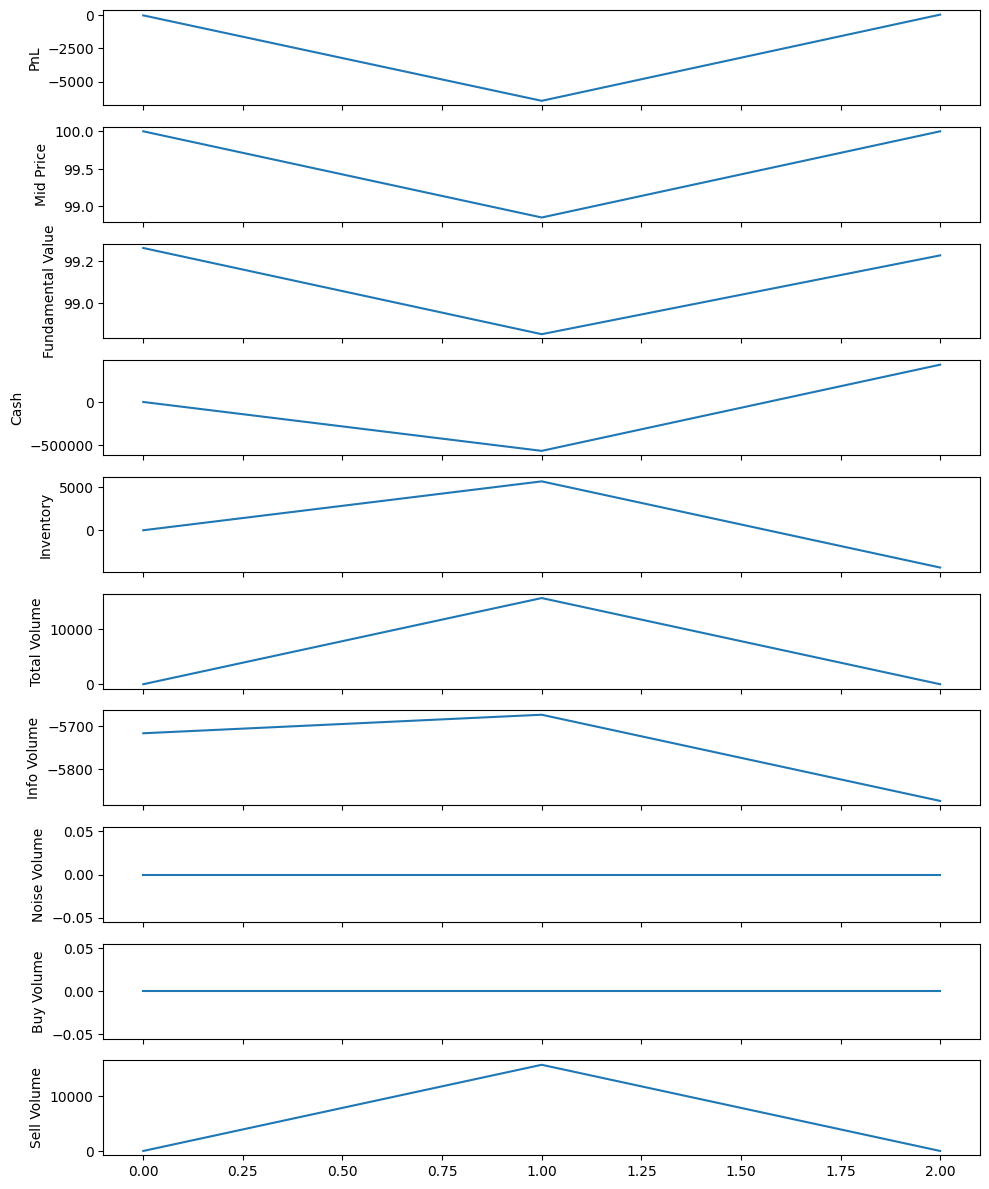

In [378]:
import matplotlib.pyplot as plt
mm = SimpleMarketMaker()
of = OrderFlow()
ob = OrderBook()
rng = np.random.default_rng(seed=45)

def moving_average(data, window_size):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

def simulate(order_book, order_flow, market_maker, timesteps):
    # Market Maker Trackers 
    pnl = np.zeros(timesteps)
    mp = np.zeros_like(pnl)
    fund_value = np.zeros_like(pnl)
    cash = np.zeros_like(pnl)
    inventory = np.zeros_like(pnl)
    volume_traded = np.zeros_like(pnl)

    # Order Flow Trackers
    info_volume = np.zeros_like(pnl)
    noise_volume = np.zeros_like(pnl)

    # Order Book Trackers
    buy_volume = np.zeros_like(pnl)
    sell_volume = np.zeros_like(pnl)

    for t in range(timesteps):
        # Simulate order flow 
        orders = order_flow.generate_orders(order_book)
        for order in orders:
            order_book.process_order(order)
        
        # Market Maker updates quotes
        market_maker.update(order_book)
        order_book.update_fundamental_value()

        # trackers
        market_maker_stats = market_maker.get_stats()
        cash[t] = market_maker_stats["Cash"]
        inventory[t] = market_maker_stats["Inventory"]
        volume_traded[t] = order_book.buy_volume + order_book.sell_volume
        fund_value[t] = order_book.fundamental_value
        
        info_volume[t] = order_flow.info_volume
        noise_volume[t] = order_flow.noise_volume

        buy_volume[t] = order_book.buy_volume
        sell_volume[t] = order_book.sell_volume

        # Reset order book volumes for next timestep
        order_book.reset_volumes()

        # Market Maker updates pnl
        pnl[t] = market_maker.pnl(order_book)
        print(f"spread: {order_book.spread}, pnl: {pnl[t]}, inventory: {inventory[t]}")
        print(order_book.best_bid, order_book.mid_price)
        mp[t] = order_book.fundamental_value if order_book.mid_price is None else order_book.mid_price
    
    return [pnl, mp, fund_value, cash, inventory, volume_traded, info_volume, noise_volume, buy_volume, sell_volume]


tracker_names = [
    "PnL",
    "Mid Price",
    "Fundamental Value",
    "Cash",
    "Inventory",
    "Total Volume",
    "Info Volume",
    "Noise Volume",
    "Buy Volume",
    "Sell Volume"
]
trackers = simulate(ob, of, mm, 3)
fig, axes = plt.subplots(nrows=len(trackers), sharex=True, figsize=(10, 12))
for i in range(len(axes)):
    axes[i].plot(trackers[i])
    axes[i].plot(moving_average(trackers[i], 100))
    axes[i].set_ylabel(tracker_names[i])

fig.tight_layout()
print(trackers[6][0:2])
print(trackers[0][0:2])